## import library yang digunakan

In [78]:
import operator
from itertools import chain, combinations
from collections import defaultdict
import pandas as pd

## fungsi subsets

In [79]:
def subsets(arr):
    """Returns non empty subsets of arr"""
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])

def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
    """calculates the support for items in the itemSet and returns a subset
       of the itemSet each of whose elements satisfies the minimum support"""
    _itemSet = set()
    localSet = defaultdict(int)

    for item in itemSet:
        for transaction in transactionList:
            if item.issubset(transaction):
                freqSet[item] += 1
                localSet[item] += 1
    
    for item, count in localSet.items():
        support = float(count) / len(transactionList)
        
        if support >= minSupport:
            _itemSet.add(item)
    
    return _itemSet

def joinSet(itemSet, length):
    """Join a set with itself and returns the n-element itemsets"""
    return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])

## fungsi returnItemsWithMinSupport

In [80]:

def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        
        for item in transaction:
            itemSet.add(frozenset([item])) # Generate 1-itemSets
    
    return itemSet, transactionList

def runApriori(data_iter, minSupport, minConfidence):
    """
    Run the apriori algorithm. data_iter is a record iterator
    Return both:
    - items (tuple, support)
    - rules (pretuple, posttuple, confidence)
    """
    itemSet, transactionList = getItemSetTransactionList(data_iter)

    freqSet = defaultdict(int)
    largeSet = dict()
    # Global dictionary which stores (key=n-itemSets, value=support)
    # which satisfy minSupport

    oneCset = returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet)
    currentLset = oneCset
    k = 2
    while currentLset:
        largeSet[k - 1] = currentLset
        currentLset = joinSet(currentLset, k)
        currentCset = returnItemsWithMinSupport(currentLset, transactionList, minSupport, freqSet)
        currentLset = currentCset
        k += 1

    def getSupport(item):
        """ local function which Returns the support of an item """
        return float(freqSet[item]) / len(transactionList)

    toRetItems = []
    for key, value in largeSet.items():
        toRetItems.extend([(tuple(item), getSupport(item)) for item in value])

    toRetRules = []
    for key, value in list(largeSet.items())[1:]:
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item) / getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)), confidence))
    return toRetItems, toRetRules

## fungsi printResult

In [81]:
def printResults(items, rules):
    print("------------ITEMS-----------------")
    for item, support in sorted(items, key=operator.itemgetter(1)):
        print(f"item: {item} , {support:.3f}")

    for item, support in sorted(items, key=operator.itemgetter(1)):
        print(f"item: {item} , {support:.3f}")

    print("\n------------RULES-----------------")
    for rule, confidence in sorted(rules, key=operator.itemgetter(1)):
        pre, post = rule
        print(f"Rule: {pre} ==> {post} , {confidence:.3f}")
    print("\n")

## fungsi dataFromFile

In [82]:
def dataFromFile(fname):
    """ Function which reads from the file and yields a generator """
    file_iter  = open(fname, 'r')
    for line in file_iter:
        line = line.strip().rstrip(",")
        record = frozenset(line.split(","))
        yield record


## jalankan operasi asosiasi rule

In [83]:
df = pd.read_excel("D:\\Studied_at_UNP\\SEMESTER-5\\praktikum_data_mining\\praktikum_4\\Data Alumni.xlsx")

minSupport = 0.15
minConfidence = 0.6

# ubah ke list of list
data_iter = df.astype(str).values.tolist()

items, rules = runApriori(data_iter, minSupport, minConfidence)
printResults(items, rules)

------------ITEMS-----------------
item: ('2012',) , 0.250
item: ('4',) , 0.250
item: ('31',) , 0.250
item: ('3.24',) , 0.250
item: ('32',) , 0.250
item: ('2016', '32') , 0.250
item: ('2009', '32') , 0.250
item: ('2016', '2012') , 0.250
item: ('2009', '3.24') , 0.250
item: ('2016', '4') , 0.250
item: ('2016', '3.24') , 0.250
item: ('2.4', '4') , 0.250
item: ('2012', '4') , 0.250
item: ('2016', '31') , 0.250
item: ('2.4', '31') , 0.250
item: ('7', '32') , 0.250
item: ('3.24', '7') , 0.250
item: ('2.4', '2012') , 0.250
item: ('2016', '3.24', '7') , 0.250
item: ('2009', '2016', '32') , 0.250
item: ('2.4', '2016', '31') , 0.250
item: ('2009', '3.24', '2016') , 0.250
item: ('2016', '7', '32') , 0.250
item: ('2.4', '2016', '4') , 0.250
item: ('2016', '2012', '4') , 0.250
item: ('2.4', '2016', '2012') , 0.250
item: ('2.4', '2012', '4') , 0.250
item: ('2009', '7', '32') , 0.250
item: ('2009', '3.24', '7') , 0.250
item: ('2016', '7', '2009', '32') , 0.250
item: ('2016', '7', '2009', '3.24') , 0

## type data dari kolom

In [84]:
df.dtypes

No               int64
NIM              int64
TTL             object
IPK            float64
Masa Tunggu    float64
Tahun Masuk      int64
Tahun Lulus      int64
Gaji             int64
TOEFL            int64
Masa Studi       int64
Umur             int64
dtype: object

## Data Processing

In [85]:
df.head(5)

# mengganti kolom IPK menjadi tipe data int
df['IPK'] = df['IPK'].astype(int)
df['NIM'] = df['NIM'].astype(str).str.strip()

df.dropna(axis=0, subset=['NIM'], inplace=True)

df = df[~df['NIM'].str.contains('3')]

## Data Transformation

In [86]:
# Convert NIM to string before using .str.contains
tabelPuncak = (df['NIM'].astype(str).str.contains('21').groupby(df['NIM']).transform('sum') >= 3).reset_index().set_index('NIM')

tabelPuncak.head()

,index
NIM,
False,1
False,2
False,3
False,4
False,5


## clustering

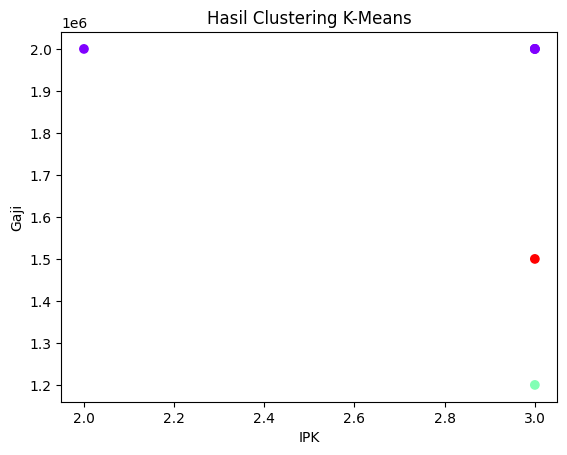

In [87]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Menentukan jumlah cluster yang diinginkan
k = 3

# Memilih kolom yang akan digunakan untuk clustering (contoh: IPK dan Gaji)
data_for_clustering = df[['IPK', 'Gaji']]

# Melakukan K-Means clustering
kmeans = KMeans(n_clusters=k)
df['Cluster'] = kmeans.fit_predict(data_for_clustering)

# Visualisasi hasil clustering
plt.scatter(df['IPK'], df['Gaji'], c=df['Cluster'], cmap='rainbow')
plt.xlabel('IPK')
plt.ylabel('Gaji')
plt.title('Hasil Clustering K-Means')
plt.show()